# Answering the questions

✔️ Answer the questions below (briefly):

🌈Is fully-connected model a good one for sequential data? Why? How about for image data? Is it good? Why?

- A fully-connected model is not a good one for sequential data because it does not capture the temporal dependencies or order of the data.

- For image data, a fully-connected model is also not a good one because it does not exploit the spatial structure or locality of the data.


🌈What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?


- gradient vanishing and gradient explosion are two problems that can occur when training deep neural networks with backpropagation. They refer to the situation where the error gradients become very small (vanishing) or very large (exploding) as they are propagated through the network layers, which can lead to slow or unstable learning.

- To mitigate these problems, LSTM and GRU networks use a gating mechanism that allows them to selectively remember or forget information from previous time steps.


🌈What is multi-objective/multi-task learning? What is multi-modality learning? How do you use them in this assignment?

- multi-objective/multi-task learning training of a neural network to perform multiple related tasks simultaneously
- Multi-modality learning (MML) refers to the training of a neural network to learn from multiple modalities of data, such as images, speech, text, or other types of input


🌈What is the difference among xgboost, lightgbm and catboost

- each of these frameworks has its own strengths and weaknesses
- Speed : LightGBM and CatBoost are typically faster than XGBoost
- Memory usage : LightGBM and CatBoost are designed to use less memory than XGBoost.
- Handling categorical features: CatBoost is specifically designed to handle categorical features more effectively than XGBoost or LightGBM
- Regularization : LightGBM and CatBoost both offer additional regularization techniques that are not available in XGBoost

# Problem Formulation

## Problem Definition

Problem here is about building a model to classify the price

Input: summary and image (7627) for a training dataset. 

Output: price (7627).

## Function
text preprocessing -> tokenization and vectorization each text ->training the model -> classification and prediction.

## Challenges

We have a **Uncleaned and untranslated Unbalanced** data set so maybe will take some time to preprocess it and train it.

## Model impact

Predicting the actual price class beginner, plus, premium and Type


## The ideal solution

Using Dropout with Drop rate of 0.3

# Importing Libraries and check data

In [ ]:
# Installing txtai for translating
!pip install git+https://github.com/neuml/txtai
!pip install sacremoses

  Cloning https://github.com/neuml/txtai to /tmp/pip-req-build-pc1gziui
  Running command git clone --filter=blob:none --quiet https://github.com/neuml/txtai /tmp/pip-req-build-pc1gziui
  Resolved https://github.com/neuml/txtai to commit 39a41fa86591c037c20c73bfc76d136e7fad9f59
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 65.7 MB/s eta 0:00:0000:0100:01
  Created wheel for txtai: filename=txtai-5.5.0-py3-none-any.whl size=167203 sha256=873bae3134b06ad313f6b16bc93fa833fac871e112ee3e98cdc42871f2706031
  Stored in directory: /tmp/pip-ephem-wheel-cache-3lile90e/wheels/83/d6/ae/6b41733966092887bf61f691622261d990943588a03e5cd0be
Successfully built txtai
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 20.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pprint import pprint
import collections
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D 
from tensorflow.keras.layers import MultiHeadAttention

In [ ]:
# Reading training and testing Data from kaggle

df_train = pd.read_csv('/kaggle/input/copy-of-cisc-873-dm-w23-a4/a4/train_xy.csv')
df_test = pd.read_csv('/kaggle/input/copy-of-cisc-873-dm-w23-a4/a4/test_x.csv')

In [ ]:
# We Can See that there is other Language Beside English (Row 5), So we will deal with it later
df_train.head()

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0


In [ ]:
df_test.head()

,id,summary,image
0,0,Charming warm house is ready to host you here ...,img_test/0.jpg
1,1,"La chambre est spacieuse et lumineuse, dans un...",img_test/1.jpg
2,2,Grande chambre confortable située au sous-sol ...,img_test/2.jpg
3,3,"Près d’un Métro, ligne orange. 10 minutes à pi...",img_test/3.jpg
4,4,Very bright appartment and very cosy. 2 separa...,img_test/4.jpg


**Check the Shape of the training and test Data**

In [ ]:
print("Training Date Shape: ", df_train.shape)
print("Testing Date Shape: ", df_test.shape)

Training Date Shape:  (7627, 4)
Testing Date Shape:  (7360, 3)


# Part 1: Data Preprocessing

**First We Will Translate The Text To English for better Acuuracy In The Training**

**We Will Translate The Data Using txtai**

In [ ]:
from txtai.pipeline import Translation

# instantiating a translation pipeline
tra = Translation()

In [ ]:
# Applying The Translation Function on The Train And Test Data
df_train["summary"] = df_train["summary"].apply(lambda x: tra(str(x), "en"))
df_test["summary"] = df_test["summary"].apply(lambda x: tra(str(x), "en"))

In [ ]:
# Checking the Output, We Notice that Row Number 5 Already got translated Successfully
df_train.head()

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Couch and cozy accommodation 10 minutes from d...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Very large apartment ''rustic'' and very nice ...,img_train/4.jpg,Apartment,0


In [ ]:
# Checking the target Column
df_train[['price']].value_counts()

price
0        4737
1        2403
2         487
dtype: int64

<AxesSubplot:xlabel='count', ylabel='price'>

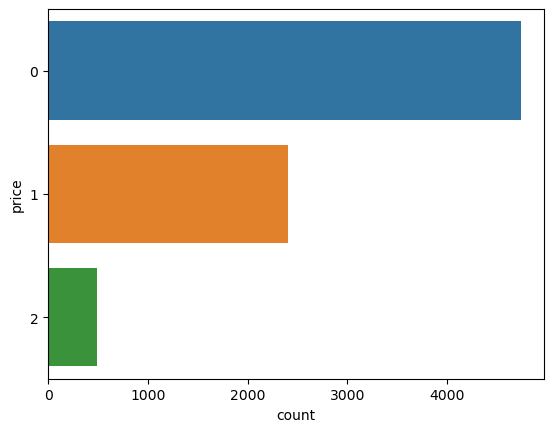

In [ ]:
# We Can See that the Data is Unbalanced
sns.countplot(y="price", data = df_train)

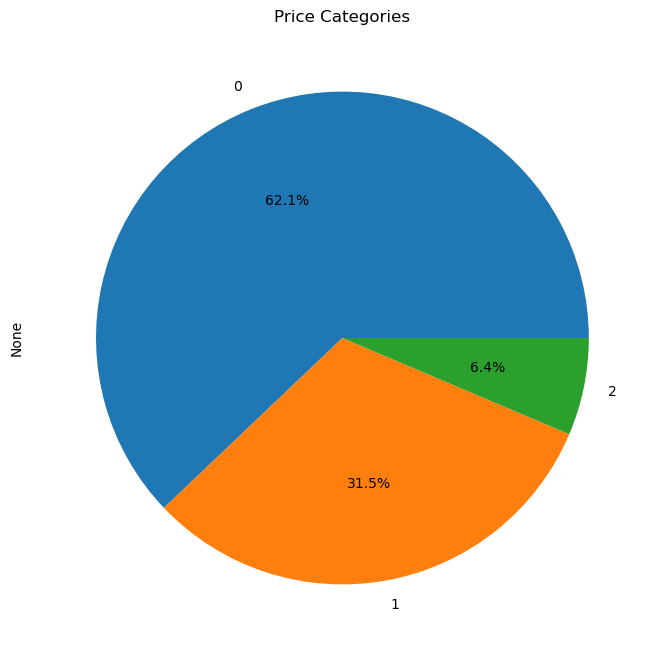

In [ ]:
# Display price unique values
price = df_train.groupby('price').size()

# Plotting The Data Using pandas
price.plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.1f%%')
plt.title("Price Categories")
plt.show()

In [ ]:
# preprocess image data

def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64)) # read each image as a greyscale image size (64x64x2)
        arr = np.array(image) # convert each image to an array
    except:
        arr = np.zeros((64, 64, 2)) # if an image can't be loaded, return an array of zeros (same size: 64x64x2)
    return arr

In [ ]:
# loading images:
x_image = np.array([load_image(i) for i in tqdm(df_train.image)]) # load each image from the provided directory using the function created above

# loading summary: (force convert some of the non-string cell to string)
x_train_text = df_train['summary'].astype('str')

  0%|          | 0/7627 [00:00<?, ?it/s]

**Let's encode the prediction labels (type & price) and calculate the total number of unique labels. After, lets split the dataset into training set and testing set.**

In [ ]:
# labels:
y_price = df_train.price # price category/label, either 0, 1, or 2 corresponding to beginner, plus, or premium respectively
y_type = df_train.type.astype('category').cat.codes # rental type label, categorically encode 24 available property types (i.e. hotel, apartment, villa, boat, etc.)

len_price = len(y_price.unique()) # number of unique labels for price
len_type = len(y_type.unique()) # number of unique labels for rental type
print('unique values for price category', len_price, y_price.unique()) # print them so we can see the unique values for our labels
print('unique values for type category', len_type, y_type.unique())

# splitting:

# the following creates training and validation splits for our image and text feature spaces
# along with our two label sets, price and rental type
x_tr_image, x_vl_image, x_tr_text, x_vl_text, y_tr_price, y_vl_price, y_tr_type, y_vl_type = train_test_split(x_image, x_train_text, y_price, y_type, test_size=0.2) # our validation splits are a hold-out set containing 20% of the training set

unique values for price category 3 [1 0 2]
unique values for type category 24 [ 1 17 22 10 18 20  5  2  8  4 23 13 15 16 14 11 19  0 21  3  6 12  7  9]


**Here we will use the "Tokenizer":** 
* By turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf.


**It takes some arguments:**
* **num_words** the maximum number of words to keep, based on word frequency.  
      Only the most common num_words-1 words will be kept.
* **filters** 	a string where each element is a character that will be filtered from the texts.
      The default is all punctuation, plus tabs and line breaks, minus the ' character.
* **lower** 	boolean. Whether to convert the texts to lowercase.
* **split** 	str. Separator for word splitting.
* **char_level** 	if True, every character will be treated as a token.
* **oov_token** 	if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls.


**Result:**

All punctuation is removed, turning the texts into space-separated sequences of words (words maybe include the ' character). These sequences are then split into lists of tokens. They will then be indexed or vectorized.

In [ ]:
vocab_size = 40000 # enforce a threshold on the number of unique words that are tokenized
max_len = 100 # maximum sequence length of a text string, anything longer will be truncated to 100 words


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size) # initialize tokenizer with a vocabulary size of 40000
tokenizer.fit_on_texts(x_tr_text) # update the vocabulary by fitting on the corpus of text contained in rental text descriptions, keeping only the most common 40000 words


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text), # transforms each list entry to a sequence of integers based on the vocabulary created from fitting the tokenizer on the training set above
        maxlen=max_len, # enforce max sequence length of 100
        padding='post', # if a sequence length is less than 100, add padding at the end to make it 100 words long
    )
    

# padding is done inside: 
x_tr_text_id = _preprocess(x_tr_text) # preprocess and tokenize list of training sequences
x_vl_text_id = _preprocess(x_vl_text) # preprocess and tokenize list of validation sequences


In [ ]:
# number of unique words contained in the vocabulary
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


# Part 2: Building The Models

## Helper Functions

In [ ]:
# method used to plot history after training to explore model behaviour
def results_viz(history):

  # generate a figure containing 3 plots displayed horizontally
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
  fig.suptitle('Model Results')
  
  # first we display the training price accuracy vs. the validation price accuracy
  ax1.plot(history.history['price_sparse_categorical_accuracy'])
  ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
  ax1.set_title('price accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train_price', 'validation_price'], loc='upper left')

  # same with the other specified accuracy metric, type accuracy
  ax2.plot(history.history['type_sparse_categorical_accuracy'])
  ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
  ax2.set_title('type accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train_type', 'validation_type'], loc='upper left')

  # on the last axis, we plot the training loss against the validation loss (w.r.t. price and type combined)
  ax3.plot(history.history['loss'])
  ax3.plot(history.history['val_loss'])
  ax3.set_title('model loss')
  ax3.set_ylabel('loss')
  ax3.set_xlabel('epoch')
  ax3.legend(['train', 'validation'], loc='upper left')

  plt.show() # display the figure

# method used to generate predictions on test set, adopted from code in template
def test(model, filename):
  y_predict = model.predict(
      {
          'summary': x_test_summary,
          'image': x_test_image
      }
  )
  price_predicted = y_predict['price'] 
  price_category_predicted = np.argmax(price_predicted, axis=1) 

  # create the submission dataframe/csv for submission
  pd.DataFrame(
      {'id': df_test.id,
      'price': price_category_predicted}).to_csv(f'{filename}.csv', index=False)

def compile(model, lr=0.001):
  # compile model
  model.compile(
      optimizer=Adam(learning_rate=lr), # using Adam for optimization
      # measuring sparse categorical cross-entropy loss for both price and type labels
      # sparse categorical cross-entropy is used since our labels are integers
      loss={
          'price': 'sparse_categorical_crossentropy',
          'type': 'sparse_categorical_crossentropy',
      },
      # equally weight the loss w.r.t. both labels
      loss_weights={
          'price': 0.5,
          'type': 0.5,       
      },
      # evaluation metric for this task is accuracy, so we measure sparse categorical accuracy for both targets
      # again, our labels are categorical integers, so we use sparse categorical accuracy
      metrics={
          'price': ['SparseCategoricalAccuracy'],
          'type': ['SparseCategoricalAccuracy'],
      },
  )

def train(model, cbs, epochs=20, batch=16, val=0.2):
  # fit our model on our training data
  history = model.fit(
      # our inputs: tokenized text sequences and resized image samples
      x={
          'summary': x_tr_text_id,
          'image': x_tr_image
      },
      # our outputs: price and rental type categories
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
      epochs=epochs, # variable, number of iterations over all training data
      batch_size=batch, # variable batch size, samples processed before updating gradients
      # our validation splits for our two input sets and our two target attributes
      validation_data=(
          {
              'summary': x_vl_text_id,
              'image': x_vl_image
          }, 
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      validation_split=val, # validate on a hold-out set of 20%, even though splits were already created above???? This is redundant.
      # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
      callbacks=cbs,
      verbose=1 # one line per epoch displaying performance metrics
  )
  return history

## Trial 0 (Main Trial)

### Define a Learning Model

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len)) # input shape for batches of text sequences (100 words long)
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding


# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape to (288,)


# fusion:
fused = tf.concat([averaged, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile model
model.compile(
    optimizer=Adam(), # using Adam for optimization
    # measuring sparse categorical cross-entropy loss for both price and type labels
    # sparse categorical cross-entropy is used since our labels are integers
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    # equally weight the loss w.r.t. both labels
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    # evaluation metric for this task is accuracy, so we measure sparse categorical accuracy for both targets
    # again, our labels are categorical integers, so we use sparse categorical accuracy
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary() # print the structure of the model defined above 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   16416       ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                              

### Model Training

**Based on the training/validation performance, you can adjust the epochs to be trained. Early stoping is watching the validation loss on type prediction (assuming that it is the main task we would like to perform)**

In [ ]:
# fit our model on our training data
history = model.fit(
    # our inputs: tokenized text sequences and resized image samples
    x={
        'summary': x_tr_text_id,
        'image': x_tr_image
    },
    # our outputs: price and rental type categories
    y={
        'price': y_tr_price,
        'type': y_tr_type,
    },
    epochs=20, # train for 20 epochs (iterations over all training data)
    batch_size=16, # batch size of 16 (samples processed before updating gradients)
    # our validation splits for our two input sets and our two target attributes
    validation_data=(
        {
            'summary': x_vl_text_id,
            'image': x_vl_image
         }, 
        {
            'price': y_vl_price,
            'type': y_vl_type,
        }),
    validation_split=0.2, # validate on a hold-out set of 20%, even though splits were already created above???? Pretty sure this is redundant.
    # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1 # one line per epoch displaying performance metrics
)

Epoch 1/20
382/382 [==============================] - 35s 75ms/step - loss: 1.0339 - price_loss: 0.8505 - type_loss: 1.2174 - price_sparse_categorical_accuracy: 0.6202 - type_sparse_categorical_accuracy: 0.7582 - val_loss: 0.9312 - val_price_loss: 0.8202 - val_type_loss: 1.0422 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 2/20
382/382 [==============================] - 6s 16ms/step - loss: 0.8852 - price_loss: 0.7968 - type_loss: 0.9736 - price_sparse_categorical_accuracy: 0.6271 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.8940 - val_price_loss: 0.7802 - val_type_loss: 1.0077 - val_price_sparse_categorical_accuracy: 0.6474 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 3/20
382/382 [==============================] - 4s 10ms/step - loss: 0.8349 - price_loss: 0.7382 - type_loss: 0.9317 - price_sparse_categorical_accuracy: 0.6660 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.8643 - val_price_loss: 0.7451

### Model Visualization

In [ ]:
# let's try training longer to see if a trend presents itself over time
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=10,)]

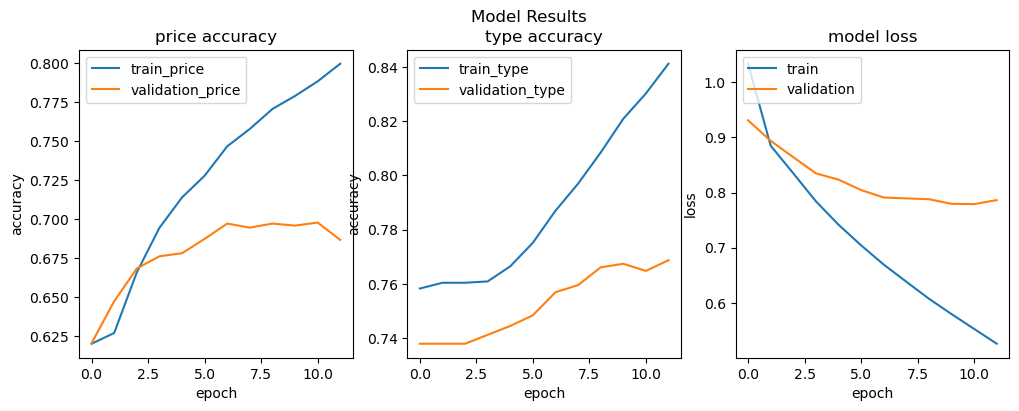

In [ ]:
# let's look at the accuracy and loss curves from the template
results_viz(history)

### Model Prediction

In [ ]:
x_test_summary = _preprocess(df_test.summary.astype(str)) # create sequences for the text summaries in the test set
x_test_image = np.array([load_image(i) for i in tqdm(df_test.image)]) # load and resize the images from the test set

  0%|          | 0/7360 [00:00<?, ?it/s]

In [ ]:
# generate predictions on the test set using the tokenized summaries and re-sized images
y_predict = model.predict(
    {
        'summary': x_test_summary,
        'image': x_test_image
    }
)

price_predicted = y_predict['price'] # this is the target attribute we care about for this task
print(price_predicted) # probability the sample belongs to each of the categories
price_category_predicted = np.argmax(price_predicted, axis=1) # pick the highest value, and assign it as the predicted class
print(price_category_predicted) # print the categorical predictions, which are in [0,1,2]


230/230 [==============================] - 1s 2ms/step
[[0.7541174  0.21153896 0.03434358]
 [0.9437599  0.0497971  0.006443  ]
 [0.8443705  0.12236667 0.03326283]
 ...
 [0.8068866  0.1742016  0.0189118 ]
 [0.9880179  0.00945426 0.0025278 ]
 [0.8362867  0.14477102 0.01894231]]
[0 0 0 ... 0 0 0]


In [ ]:
# create the submission dataframe/csv for submission
pd.DataFrame({'id': df_test.id,'price': price_category_predicted}).to_csv('submission.csv', index=False)

In [ ]:
#clear session
tf.keras.backend.clear_session()

## Trial 1, LSTM on Text

**Plans for trial 1:** 
- write some helper functions to use throughout this Notebook
- replace the reduce_mean layer with an LSTM layer and vary the number of units 

**This should make an improvement over just taking the mean of each set of embeddings for a sentence.**

In [ ]:
# copied the model from the template and modifying it here
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings

# only part I'm changing is adding an LSTM layer on top of the embedding layer
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
lstm = LSTM(50)(embedded)

# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape to (288,)


# fusion:
fused = tf.concat([lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

compile(lstm_model) # compiles the model with the helper to improve readability
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   16416       ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                              

In [ ]:
history = train(lstm_model, callbacks) # use train helper to improve readability

Epoch 1/20
382/382 [==============================] - 23s 51ms/step - loss: 0.9839 - price_loss: 0.8506 - type_loss: 1.1172 - price_sparse_categorical_accuracy: 0.6178 - type_sparse_categorical_accuracy: 0.7564 - val_loss: 0.9502 - val_price_loss: 0.8365 - val_type_loss: 1.0639 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 2/20
382/382 [==============================] - 7s 19ms/step - loss: 0.9227 - price_loss: 0.8417 - type_loss: 1.0037 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9436 - val_price_loss: 0.8383 - val_type_loss: 1.0489 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 3/20
382/382 [==============================] - 5s 14ms/step - loss: 0.9224 - price_loss: 0.8415 - type_loss: 1.0033 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9458 - val_price_loss: 0.8348

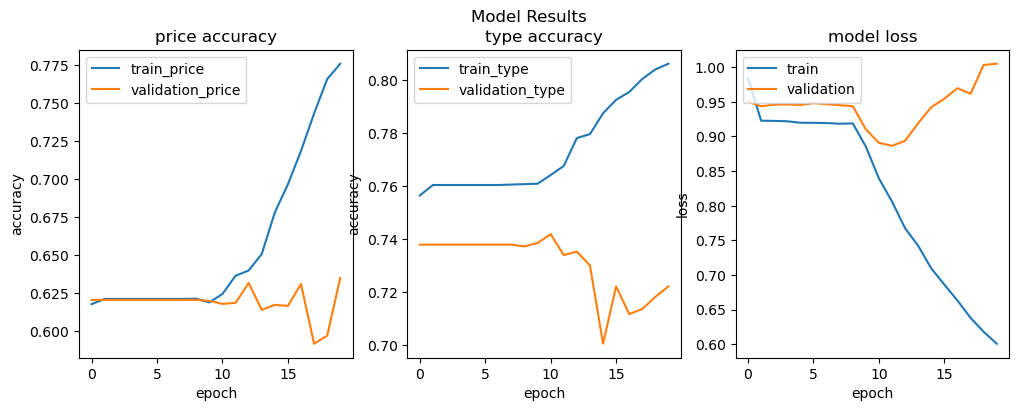

In [ ]:
# looking at the curves below, we see a similar behaviour to that in the template. 
# The model does not appear to be learning much, see the training curve.
results_viz(history)

In [ ]:
# Generate prediction File
test(lstm_model,'submission_LSTM')

230/230 [==============================] - 1s 4ms/step


## Trial 2, GRU

Plan for trial 2: Let's try a GRU layer instead And see how it goes

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
lstm = GRU(20)(embedded) # fewer hidden units might improve training time?

# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape


# fusion:
fused = tf.concat([lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
gru_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile this new model including the GRU layer and print the architecture
compile(gru_model)
gru_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 49, 49, 32)   16416       ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     4000000     ['input_3[0][0]']                
                                                                                            

In [ ]:
# train with the same hyperparameters in the template, 20 epochs with a batch size of 16
history = train(gru_model, callbacks)

Epoch 1/20
382/382 [==============================] - 22s 48ms/step - loss: 1.0159 - price_loss: 0.8528 - type_loss: 1.1791 - price_sparse_categorical_accuracy: 0.6189 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.9460 - val_price_loss: 0.8363 - val_type_loss: 1.0557 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 2/20
382/382 [==============================] - 6s 16ms/step - loss: 0.9179 - price_loss: 0.8373 - type_loss: 0.9985 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9388 - val_price_loss: 0.8330 - val_type_loss: 1.0445 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 3/20
382/382 [==============================] - 5s 14ms/step - loss: 0.8811 - price_loss: 0.8117 - type_loss: 0.9504 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7605 - val_loss: 0.9047 - val_price_loss: 0.8114

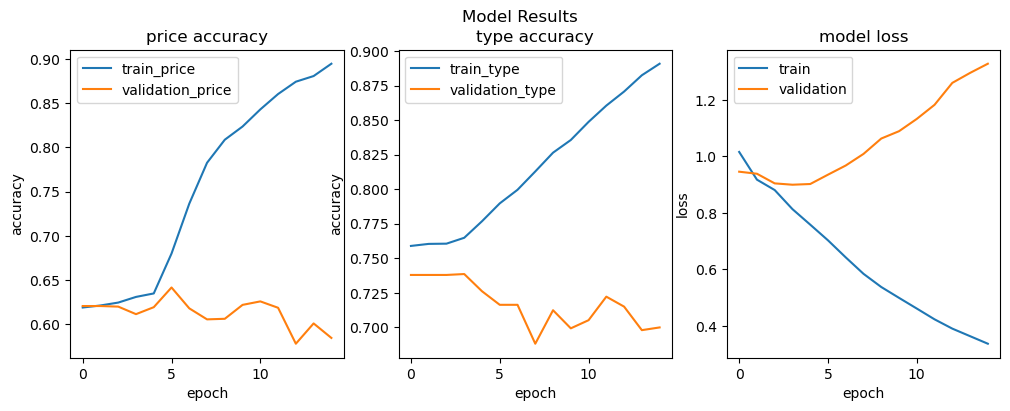

In [ ]:
results_viz(history)

In [ ]:
# Generating predictions using the GRU model
test(gru_model,'Submission_GRU')

230/230 [==============================] - 1s 3ms/step


## Trial 3 - Adding Depth to Image Layers

Plan for trial 3: Let's see what will happen when we add depth to the CNN for the image part of the network.

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
lstm = GRU(20)(embedded)

# image part
cov = Conv2D(32, (3, 3))(in_image) # convolutional layer with 32 filters, and a 3x3 mask, no padding
pl = MaxPool2D((3, 3))(cov) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
pl2 = MaxPool2D((2,2))(cov2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion:
fused = tf.concat([lstm, flattened], axis=-1) # concatenate text features with image features

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
cnn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile the model with the updated CNN component and print the summary
compile(cnn_model)
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 62, 62, 32)   608         ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 20, 20, 32)  0           ['conv2d_2[0][0]']               
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                            

In [ ]:
# training on 20 epochs with a batch size of 16, early stopping with a patience of 10
history = train(cnn_model, callbacks)

Epoch 1/20
382/382 [==============================] - 22s 49ms/step - loss: 0.9689 - price_loss: 0.8512 - type_loss: 1.0866 - price_sparse_categorical_accuracy: 0.6206 - type_sparse_categorical_accuracy: 0.7569 - val_loss: 0.9555 - val_price_loss: 0.8527 - val_type_loss: 1.0582 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 2/20
382/382 [==============================] - 8s 21ms/step - loss: 0.9271 - price_loss: 0.8436 - type_loss: 1.0106 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9441 - val_price_loss: 0.8361 - val_type_loss: 1.0522 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 3/20
382/382 [==============================] - 5s 13ms/step - loss: 0.9238 - price_loss: 0.8413 - type_loss: 1.0064 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9441 - val_price_loss: 0.8339

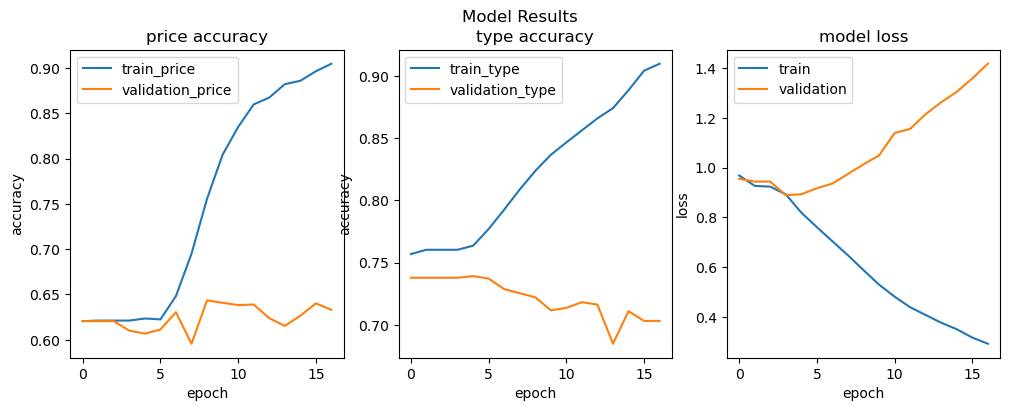

In [ ]:
# from these results, it looks like we're starting to overfit
results_viz(history)

In [ ]:
# generating predictions
test(cnn_model,'Submission_CNN')

230/230 [==============================] - 1s 4ms/step


## Trial 4 - Bi-directional

Plan for trial 4: The performance is not that great, but let's see what happens if we add bidirectionality to the GRU layer.

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
bi_gru = Bidirectional(GRU(20))(embedded) # creating a bidirectional GRU layer, with 20 units as before

# image part
cov = Conv2D(32, (3, 3))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((3, 3))(cov) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
pl2 = MaxPool2D((2,2))(cov2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion:
fused = tf.concat([bi_gru, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
bi_gru_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the bidirectional model and printing a summary of the architecture
compile(bi_gru_model)
bi_gru_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 62, 62, 32)   608         ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 20, 20, 32)  0           ['conv2d_4[0][0]']               
                                                                                                  
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                            

In [ ]:
# training on 20 epochs, batch size to 32 to improve training speed
history = train(bi_gru_model, callbacks, 20, 32)

Epoch 1/20
191/191 [==============================] - 27s 118ms/step - loss: 0.9776 - price_loss: 0.8226 - type_loss: 1.1326 - price_sparse_categorical_accuracy: 0.6327 - type_sparse_categorical_accuracy: 0.7561 - val_loss: 0.8899 - val_price_loss: 0.7587 - val_type_loss: 1.0210 - val_price_sparse_categorical_accuracy: 0.6678 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 2/20
191/191 [==============================] - 11s 57ms/step - loss: 0.8185 - price_loss: 0.7037 - type_loss: 0.9334 - price_sparse_categorical_accuracy: 0.6912 - type_sparse_categorical_accuracy: 0.7600 - val_loss: 0.8553 - val_price_loss: 0.7370 - val_type_loss: 0.9736 - val_price_sparse_categorical_accuracy: 0.6671 - val_type_sparse_categorical_accuracy: 0.7353
Epoch 3/20
191/191 [==============================] - 5s 27ms/step - loss: 0.7429 - price_loss: 0.6369 - type_loss: 0.8489 - price_sparse_categorical_accuracy: 0.7377 - type_sparse_categorical_accuracy: 0.7648 - val_loss: 0.8523 - val_price_loss: 0.76

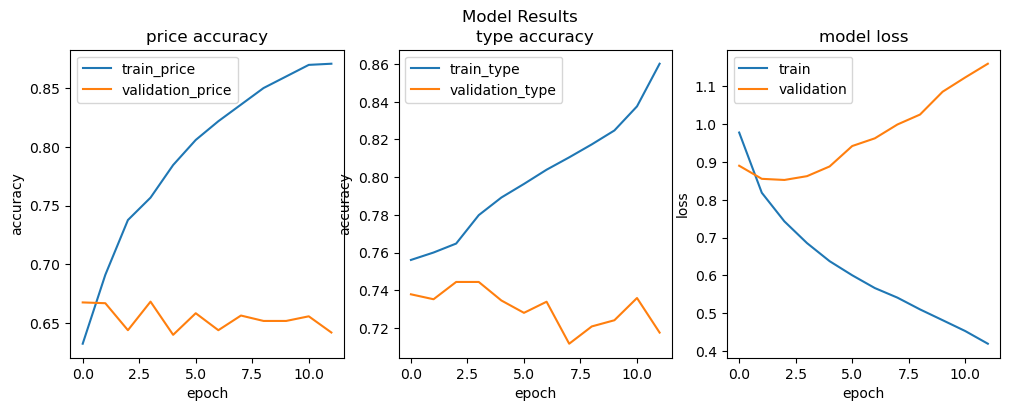

In [ ]:
results_viz(history)

In [ ]:
# generating predictions
test(bi_gru_model,'Submission_Bi')

230/230 [==============================] - 2s 5ms/step


## Trial 5, Drop-out

Plan for trial 5: Add drop-out regularization in the image component of the model to reduce the overfitting behaviour. Also using L2 recurrent regularization on the text component of the model.

In [ ]:
# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding. 
embedded = keras.layers.Embedding(tokenizer.num_words, 300)(in_text)
dropout= Dropout(.4)(embedded)
bi_directional =  Bidirectional(LSTM(5))(dropout)

# image part 
# simple conv2d.
cov1 = Conv2D(10, (16, 16) , activation='relu')(in_image) # 10 number of filters and  (15, 15) size of filter
dropout = Dropout(.4)(cov1)
pl = MaxPool2D((16, 16))(dropout)
flattened = Flatten()(pl)

# fusion - combinig both
fused = tf.concat([bi_directional, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    }
)


# compile model with optimizer, loss values for each task, 
# loss weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 49, 49, 10)   5130        ['input_13[0][0]']               
                                                                                                  
 embedding_5 (Embedding)        (None, 100, 300)     12000000    ['input_12[0][0]']               
                                                                                            

In [ ]:
# increasing the batch size to 64 to improve training speed, still 20 epochs
history = train(model, callbacks, 20, 64) # using a batch size of 64 to speed up training

Epoch 1/20


2023-04-11 22:25:03.177712: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


96/96 [==============================] - 24s 200ms/step - loss: 1.5861 - price_loss: 0.9786 - type_loss: 2.1937 - price_sparse_categorical_accuracy: 0.5558 - type_sparse_categorical_accuracy: 0.7438 - val_loss: 1.1106 - val_price_loss: 0.8498 - val_type_loss: 1.3714 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 2/20
96/96 [==============================] - 11s 109ms/step - loss: 0.9909 - price_loss: 0.8371 - type_loss: 1.1446 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9724 - val_price_loss: 0.8316 - val_type_loss: 1.1131 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 3/20
96/96 [==============================] - 7s 74ms/step - loss: 0.9297 - price_loss: 0.8307 - type_loss: 1.0287 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9509 - val_price_loss: 0.8299 - val_type_lo

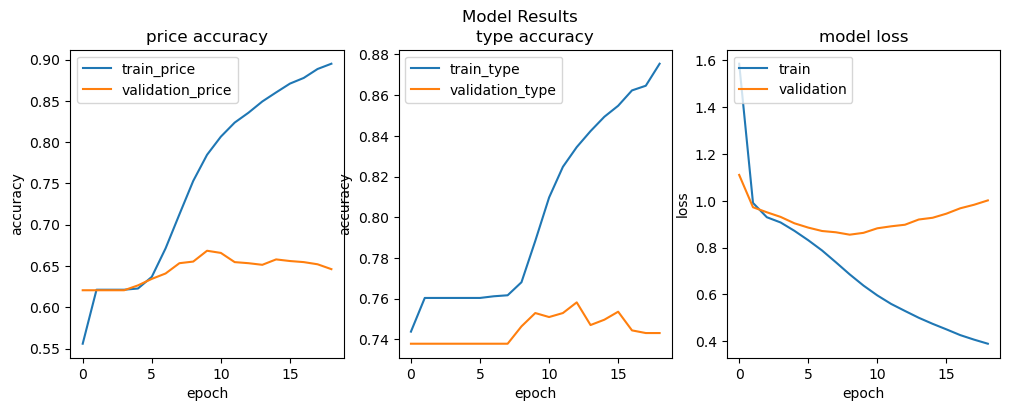

In [ ]:
# still overfitting, but the curves are much smoother, as expected
results_viz(history)

In [ ]:
# generating predictions
test(model,'Submission_Dropout')

230/230 [==============================] - 2s 5ms/step


## Trial 6, Drop-out V2

Plan for trial 6: Same As Trail 5 But using it on another Model (Trial 0) With Drop Rate 0.3

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len)) # input shape for batches of text sequences (100 words long)
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
dropout= Dropout(.3)(embedded)
averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding


# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
dropout= Dropout(.3)(cov)
pl = MaxPool2D((16, 16))(dropout) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape to (288,)


# fusion:
fused = tf.concat([averaged, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile model
model.compile(
    optimizer=Adam(), # using Adam for optimization
    # measuring sparse categorical cross-entropy loss for both price and type labels
    # sparse categorical cross-entropy is used since our labels are integers
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    # equally weight the loss w.r.t. both labels
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    # evaluation metric for this task is accuracy, so we measure sparse categorical accuracy for both targets
    # again, our labels are categorical integers, so we use sparse categorical accuracy
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary() # print the structure of the model defined above 

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 49, 49, 32)   16416       ['input_15[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dropout_4 (Dropout)            (None, 49, 49, 32)   0           ['conv2d_7[0][0]']               
                                                                                            

In [ ]:
# increasing the batch size to 64 to improve training speed, still 20 epochs
history = train(model, callbacks, 20, 64) # using a batch size of 64 to speed up training

Epoch 1/20


2023-04-11 22:27:31.567844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


96/96 [==============================] - 11s 97ms/step - loss: 1.5010 - price_loss: 0.9193 - type_loss: 2.0828 - price_sparse_categorical_accuracy: 0.6160 - type_sparse_categorical_accuracy: 0.7527 - val_loss: 1.0038 - val_price_loss: 0.8313 - val_type_loss: 1.1763 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 2/20
96/96 [==============================] - 5s 48ms/step - loss: 0.9199 - price_loss: 0.8295 - type_loss: 1.0103 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9551 - val_price_loss: 0.8266 - val_type_loss: 1.0835 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 3/20
96/96 [==============================] - 4s 39ms/step - loss: 0.9031 - price_loss: 0.8200 - type_loss: 0.9863 - price_sparse_categorical_accuracy: 0.6212 - type_sparse_categorical_accuracy: 0.7604 - val_loss: 0.9394 - val_price_loss: 0.8185 - val_type_loss:

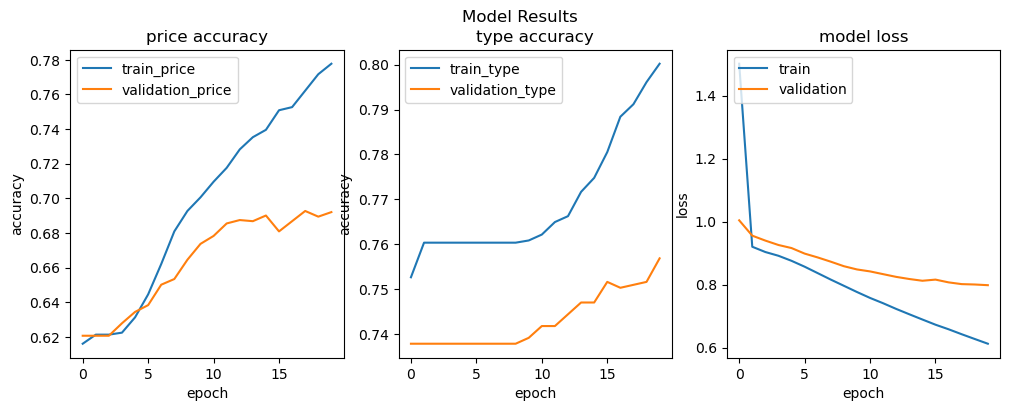

In [ ]:
results_viz(history)

In [ ]:
# generating predictions I Found that Using DropOut = 0.3 is the best I can get so far
test(model,'Submission_DropoutVFinal')

230/230 [==============================] - 1s 2ms/step


# Bonus Trial Using VGG

Using it having some adventages includes saving of resources and improved efficiency when training new models hence we expect some enhancement in performance.

In [ ]:
from keras.applications.vgg16 import VGG16

# VGG needs input images with 3 channels, so I'll extend the training data to have 3 channels and appear RGB
# x_tr_image is currently (6101, 64, 64, 2)
rgb_tr = x_tr_image[:,:,:,0]
rgb_vl = x_vl_image[:,:,:,0]
# rgb.shape # now it's (6101, 64, 64)
rgb_tr = np.repeat(rgb_tr[..., np.newaxis], 3, -1) # repeat the same values across 3 channels
rgb_vl = np.repeat(rgb_vl[..., np.newaxis], 3, -1) # repeat the same values across 3 channels

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Rescaling

# bringing VGG16 into the mix
base = VGG16(include_top=False, input_shape=(64,64,3)) # instantiating the base model we wish to tune
base.trainable = False # freezing the weights

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
attention = MultiHeadAttention(num_heads=2, key_dim=2)(embedded, embedded)
bi_lstm = Bidirectional(GRU(50, recurrent_regularizer='l2'))(attention)


# image part
scaling = Rescaling(1./127.5, offset=-1)(in_image) # rescaling to [-1,1] for VGG16
vgg = base(scaling, training=False) # pass the base model the scaled inputs
pl = GlobalAveragePooling2D()(vgg) # global average pooling, pretty much the same as flattening
do = Dropout(0.2)(pl) # dropout at a rate of 20%
fl = Flatten()(do) # flattening anyways


# fusion:
fused = tf.concat([bi_lstm, fl], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
attn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the updated attention model and printing the summary
compile(attn_model)
attn_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 64, 64, 3)    0           ['input_18[0][0]']               
                                                                                                  
 input_17 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 2, 2, 512)    14714688    ['rescaling_1[0][0]']            
                                                                                            

In [ ]:
# history = train(lstm_model, callbacks)
history = attn_model.fit(
      # our inputs: tokenized text sequences and resized image samples
      x={
          'summary': x_tr_text_id,
          'image': rgb_tr # can't use my helper function as I have a different image input
      },
      # our outputs: price and rental type categories
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
      epochs=20, # train for 20 epochs (iterations over all training data)
      batch_size=32, # batch size of 16 (samples processed before updating gradients)
      # our validation splits for our two input sets and our two target attributes
      validation_data=(
          {
              'summary': x_vl_text_id,
              'image': rgb_vl # can't use my helper function as I have a different validation set
          }, 
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      # validation_split=0.2, # validate on a hold-out set of 20%, even though splits were already created above???? This is redundant.
      # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
      callbacks=[
          tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, ) # setting patience back to 5
      ],
      verbose=1 # one line per epoch displaying performance metrics
  )

Epoch 1/20
191/191 [==============================] - 25s 94ms/step - loss: 1.2929 - price_loss: 0.8648 - type_loss: 1.1937 - price_sparse_categorical_accuracy: 0.6063 - type_sparse_categorical_accuracy: 0.7096 - val_loss: 0.9499 - val_price_loss: 0.8272 - val_type_loss: 1.0233 - val_price_sparse_categorical_accuracy: 0.6206 - val_type_sparse_categorical_accuracy: 0.7379
Epoch 2/20
191/191 [==============================] - 9s 48ms/step - loss: 0.8623 - price_loss: 0.7969 - type_loss: 0.9132 - price_sparse_categorical_accuracy: 0.6284 - type_sparse_categorical_accuracy: 0.7617 - val_loss: 0.9012 - val_price_loss: 0.8209 - val_type_loss: 0.9790 - val_price_sparse_categorical_accuracy: 0.6337 - val_type_sparse_categorical_accuracy: 0.7412
Epoch 3/20
191/191 [==============================] - 8s 43ms/step - loss: 0.8007 - price_loss: 0.7559 - type_loss: 0.8438 - price_sparse_categorical_accuracy: 0.6409 - type_sparse_categorical_accuracy: 0.7681 - val_loss: 0.8854 - val_price_loss: 0.7788

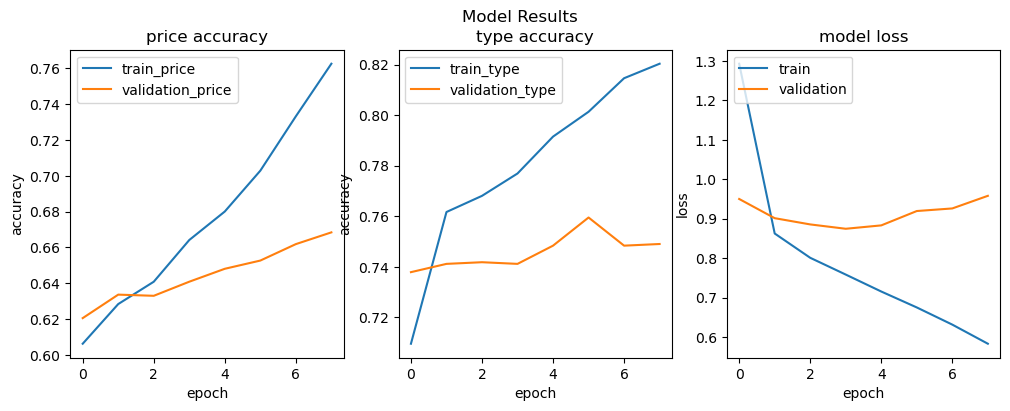

In [ ]:
# this looks a lot better! Typical training/validation loss curve where we can see overfitting start to occur after just a few epochs
results_viz(history)

In [ ]:
# preprocess the test images the same way as our training and validation sets
rgb_test = x_test_image[:,:,:,0]
rgb_test = np.repeat(rgb_test[..., np.newaxis], 3, -1) # repeat the same values across 3 channels

In [ ]:
y_predict = attn_model.predict(
    {
        'summary': x_test_summary,
        'image': rgb_test
    }
)
price_predicted = y_predict['price'] 
price_category_predicted = np.argmax(price_predicted, axis=1) 

# create the submission dataframe/csv for submission
pd.DataFrame(
    {'id': df_test.id,
    'price': price_category_predicted}).to_csv('submission_Bonus.csv', index=False)

230/230 [==============================] - 3s 12ms/step


# Result

The LSTM And GRU Didn't preform well with Submission Accuracy = 58% and 53% And The Other Models Didn't Give That Great Of Improvement, only after using the Dropout again on the best model with Dropout Rate of 0.3 I Got better Accuracy for in Submission